### • Họ và tên: Trần Thuận Phát
### • MSSV: 21127666

### 1. Mô tả bài toán:

- Bài toán này sử dụng mô hình multi channel LSTM CNN để phân loại các lá thư được gửi tới mang nội dung có ý nghĩa là spam hay là ham (thư có ý nghĩa thông điệp)

- Dataset mà em sử dụng được lấy từ NLP Course trên trang Kaggle với tập tin là spam.csv (https://www.kaggle.com/code/matleonard/text-classification/input)

- Mô hình mà em xây dựng dựa vào bài báo mà thầy đã đăng trên moodle với việc tích hợp LSTM và CNN để thực hiện phân loại văn bản. (https://www.researchgate.net/publication/321259272_Multi-channel_LSTM-CNN_model_for_Vietnamese_sentiment_analysis)

### 2. Các thư viện sử dụng hỗ trợ giải quyết bài toán

In [11]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Concatenate, Flatten, Dropout, BatchNormalization
from keras.models import Model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

### 3. Load tập dữ liệu

In [12]:
# Tải tập dữ liệu csv
path = './data/spam.csv'
data = pd.read_csv(path)
print(data.head())

  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


### 4. Tiền xử lý dữ liệu

In [13]:
# Xóa các dòng bị thiếu dữ liệu
data.dropna(axis=1, inplace=True)
# Xuất thông tin dòng bị thiếu
print("Số lượng dòng bị thiếu của mỗi cột là: ")
print(data.isnull().sum())

Số lượng dòng bị thiếu của mỗi cột là: 
label    0
text     0
dtype: int64


### 5. Trực quan hóa dữ liệu

Số trường hợp của mỗi lớp: 
label
ham     4825
spam     747
Name: count, dtype: int64


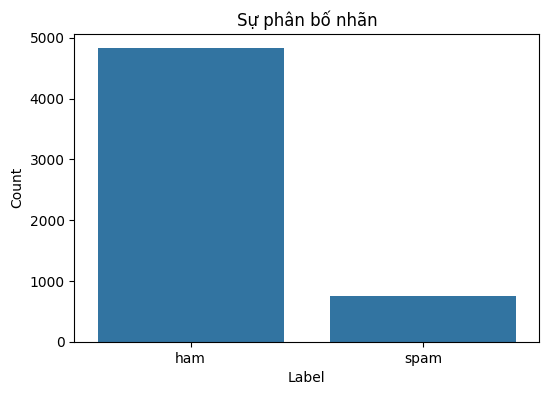

In [14]:
# Xuất ra số trường hợp của từng nhãn
print("Số trường hợp của mỗi lớp: ")
print(data['label'].value_counts())

# Trực quan hóa sự phân bố của các lớp trong nhãn
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=data)
plt.title('Sự phân bố nhãn')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

**Nhận xét**:

- Dựa vào biểu đồ trên ta thấy có sự mất cân bằng dữ liệu của 2 nhãn spam và ham. Điều đó sẽ gây ảnh hưởng đến quá trình học của mô hình và có thiên hướng nghiêng về nhãn ham. Hơn nữa, số lượng mẫu của mô hình cùng khá ít nên ta sẽ thực hiện quá trình Oversampling cho nhãn spam bằng thư viện sklearn để cân bằng dữ liệu trên trước quá trình huấn luyện.

Số trường hợp của mỗi lớp sau khi thực hiện oversampling: 
label
ham     4825
spam    4825
Name: count, dtype: int64


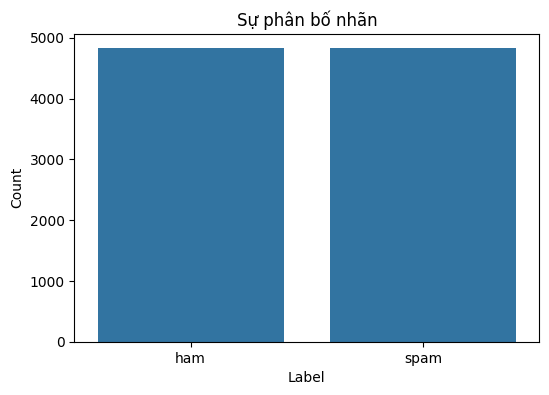

In [15]:
# Lấy ra các nhãn có lớp là ham và spam
data_ham = data[data['label'] == 'ham']
data_spam = data[data['label'] == 'spam']

# Thực hiện quá trình oversampling
data_spam_oversampling = resample(data_spam,
                               replace = True,  
                               n_samples = len(data_ham),  
                               random_state = 42)  

# Kết hợp lại thành data để huấn luyện mô hình
data = pd.concat([data_ham, data_spam_oversampling])

# Xuất ra số trường hợp của từng nhãn
print("Số trường hợp của mỗi lớp sau khi thực hiện oversampling: ")
print(data['label'].value_counts())

# Trực quan hóa sự phân bố của các lớp trong nhãn
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=data)
plt.title('Sự phân bố nhãn')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

**Nhận xét**:

- Dựa vào biểu đồ trên ta thấy cả 2 nhãn spam và ham đều đã cân bằng nhau và điều đó có thể hỗ trợ tốt khả năng học của mô hình và giảm thiểu hiện tượng mất cân bằng trong đánh giá mô hình.

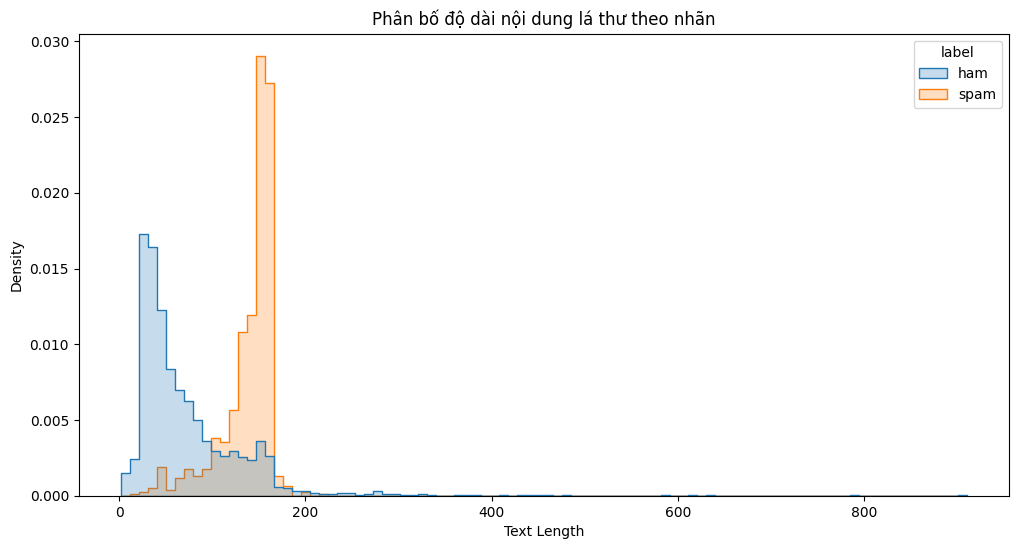

In [16]:
# Độ dài nội dung lá thư
data['text_length'] = data['text'].apply(len)

# Trực quan độ dài nội dung lá thư theo tần suất xuất hiện
plt.figure(figsize=(12,6))
sns.histplot(data, x='text_length', hue='label', element='step', stat='density', common_norm=False)
plt.title('Phân bố độ dài nội dung lá thư theo nhãn')
plt.xlabel('Text Length')
plt.ylabel('Density')
plt.show()

**Nhận xét**:

- Dựa vào biểu đồ trên ta thấy được sự phân phối về độ dài nội dung của lá thư được phân chia theo hai nhãn ham và spam hỗ trợ cho quá trình cài đặt huấn luyện.

- Các lá thư mang nội dung spam có độ dài từ khoảng lớn hơn 0 đến 300 từ.

- Các lá thư mang nội dung ham có độ dài từ khoảng lớn hơn 0 đến 1000 từ.

- Dựa vào 2 khối tần suất mang màu xanh và cam ở trên ta thấy được số lá thư mang nội dung spam sẽ có xu hướng chứa nhiều từ hơn các lá thư mang nội dung ham.

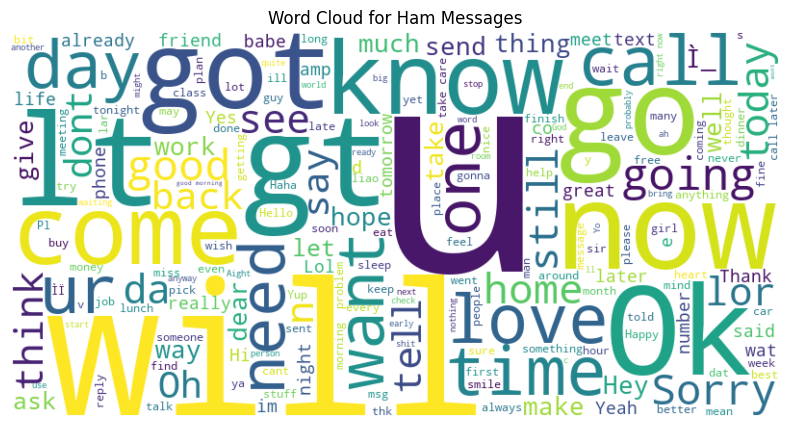

In [17]:
# ÁP dụng hiển thị word cloud cho nội dung lá thư với nhãn ham
ham_text = ' '.join(data[data['label'] == 'ham']['text'].values)
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)

plt.figure(figsize=(10,5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Ham Messages')
plt.show()

**Nhận xét**:

- Dựa vào biểu đồ trên ta thấy được những từ khóa có trong các lá thư mang nội dung ham. Chữ càng lớn và to thì tàn suất xuất hiện trong lá thư đó càng nhiều. Ví dụ như từ "will", "ok", "got", "now", "go",...

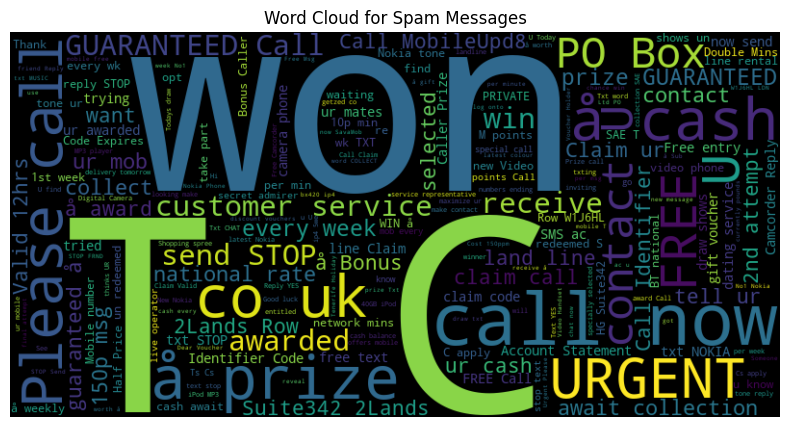

In [18]:
# ÁP dụng hiển thị word cloud cho nội dung lá thư với nhãn spam
spam_text = ' '.join(data[data['label'] == 'spam']['text'].values)
spam_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(spam_text)

plt.figure(figsize=(10,5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Spam Messages')
plt.show()

**Nhận xét**:

- Dựa vào biểu đồ trên ta thấy được những từ khóa có trong các lá thư mang nội dung spam. Chữ càng lớn và to thì tàn suất xuất hiện trong lá thư đó càng nhiều. Ví dụ như từ "Won", "urgent", "call now", "prize", "Please call",...

### 6. Chuẩn hóa dữ liệu và chuẩn bị các thông số cho quá trình huấn luyện mô hình

In [19]:
# Tiền xử lý dữ liệu
texts = data['text'].values
labels = data['label'].values

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

# Tokenize and pad the sequences
max_length = 100
vocab_size = 10000
embedding_dim = 200

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)

X = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=max_length)
y = labels_categorical

# Chia tập dữ liệu cho train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 7. Xây dựng mô hình multi channel LSTM CNN

In [20]:
# Define input layer
input_text = Input(shape=(max_length,))

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_text)

# CNN model với số lượng size kernel = (3, 5, 7)
conv_k_3 = Conv1D(filters=2, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01))(embedding_layer)
pool = MaxPooling1D(pool_size=2)(conv_k_3)
conv_k_5 = Conv1D(filters=2, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01))(pool)
pool = MaxPooling1D(pool_size=2)(conv_k_5)
conv_k_7 = Conv1D(filters=2, kernel_size=7, activation='relu', kernel_regularizer=l2(0.01))(pool)
pool = MaxPooling1D(pool_size=2)(conv_k_7)
representation_cnn = Flatten()(pool)

# LSTM model
lstm_layer = LSTM(units=128, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)(embedding_layer)
representation_lstm = Flatten()(lstm_layer)

# Kết hợp outputs từ CNN và LSTM
concatenated = Concatenate(axis=-1)([representation_cnn, representation_lstm])

# Dropout và Batch Normalization
dropout = Dropout(0.5)(concatenated)
batch_norm = BatchNormalization()(dropout)

# Fully connected layers
dense_layer = Dense(100, activation='relu', kernel_regularizer=l2(0.01))(batch_norm)
dropout_dense = Dropout(0.5)(dense_layer)

# Output layer
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(dropout_dense)

# Tạo model
model = Model(inputs=input_text, outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Xuất thông tin mô hình
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 200)             2000000   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 98, 2)                1202      ['embedding[0][0]']           
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 49, 2)                0         ['conv1d[0][0]']              
 D)                                                                                           

### 8. Huấn luyện mô hình và lưu mô hình

In [21]:
# Thực hiện dừng sớm
early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=3)

# Huấn luyện model
history_model = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4, batch_size=256, callbacks=[early_stopping])

Epoch 1/10
31/31 [==============================] - 78s 2s/step - loss: 1.7349 - accuracy: 0.9039 - val_loss: 1.5683 - val_accuracy: 0.4896
Epoch 2/10
31/31 [==============================] - 76s 2s/step - loss: 0.7002 - accuracy: 0.9924 - val_loss: 0.9582 - val_accuracy: 0.5497
Epoch 3/10
31/31 [==============================] - 83s 3s/step - loss: 0.3015 - accuracy: 0.9969 - val_loss: 0.6419 - val_accuracy: 0.8953
Epoch 4/10
31/31 [==============================] - 95s 3s/step - loss: 0.1511 - accuracy: 0.9982 - val_loss: 0.4790 - val_accuracy: 0.9674
Epoch 5/10
31/31 [==============================] - 88s 3s/step - loss: 0.0758 - accuracy: 0.9990 - val_loss: 0.4412 - val_accuracy: 0.8886
Epoch 6/10
31/31 [==============================] - 92s 3s/step - loss: 0.0474 - accuracy: 0.9994 - val_loss: 0.2874 - val_accuracy: 0.9953
Epoch 7/10
31/31 [==============================] - 91s 3s/step - loss: 0.0320 - accuracy: 0.9994 - val_loss: 0.2213 - val_accuracy: 0.9959
Epoch 8/10
31/31 [==

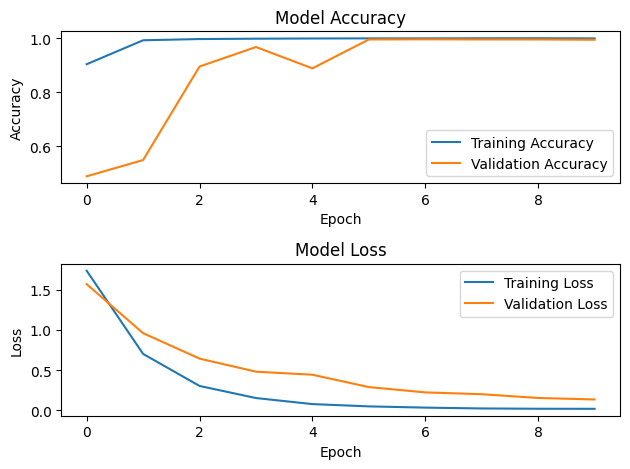

In [22]:
# Đồ thị accuracy
plt.subplot(2, 1, 1)
plt.plot(history_model.history['accuracy'], label='Training Accuracy')
plt.plot(history_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Đồ thị loss
plt.subplot(2, 1, 2)
plt.plot(history_model.history['loss'], label='Training Loss')
plt.plot(history_model.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### 9. Kiểm tra độ chính xác của mô hình

In [23]:
# Kiểm tra độ chính xác mô hình
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

61/61 [==============================] - 4s 57ms/step - loss: 0.1334 - accuracy: 0.9943
Test accuracy: 0.9943005442619324


### 10. Chạy thử mô hình với những đầu vào mới

In [24]:
# Hàm chuẩn hóa new_text và thực hiện dự đoán nhãn
def predict_new_text(text_new):
    text_sequence = tokenizer.texts_to_sequences([text_new])
    text_padded = pad_sequences(text_sequence, maxlen=max_length)
    prediction = model.predict(text_padded)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]

In [25]:
# Ví dụ ham
text_new = 'Hi, how are you?'
predicted_label = predict_new_text(text_new)
print(f'Nhãn dự đoán cho text này là: {predicted_label}')

1/1 [==============================] - 0s 444ms/step
Nhãn dự đoán cho text này là: ham


In [26]:
# Ví dụ ham
text_new = 'Ohhhhhhh, I am so suprised =)))))'
predicted_label = predict_new_text(text_new)
print(f'Nhãn dự đoán cho text này là: {predicted_label}')

1/1 [==============================] - 0s 40ms/step
Nhãn dự đoán cho text này là: ham


In [27]:
# Ví dụ ham
text_new = 'Nah I dont think he goes fishing, he is so weird'
predicted_label = predict_new_text(text_new)
print(f'Nhãn dự đoán cho text này là: {predicted_label}')

1/1 [==============================] - 0s 36ms/step
Nhãn dự đoán cho text này là: ham


In [28]:
# Ví dụ spam
text_new = 'Congratulations! You have won a free ticket to the Bahamas. Call now to claim your prize.'
predicted_label = predict_new_text(text_new)
print(f'Nhãn dự đoán cho text này là: {predicted_label}')

1/1 [==============================] - 0s 35ms/step
Nhãn dự đoán cho text này là: spam


In [29]:
# Ví dụ spam
text_new = 'Limited time offer: Buy 1 Get 1 Free on all orders!'
predicted_label = predict_new_text(text_new)
print(f'Nhãn dự đoán cho text này là: {predicted_label}')

1/1 [==============================] - 0s 61ms/step
Nhãn dự đoán cho text này là: spam


In [30]:
# Ví dụ spam
text_new = 'Click here to claim your free iPhone X now!'
predicted_label = predict_new_text(text_new)
print(f'Nhãn dự đoán cho text này là: {predicted_label}')

1/1 [==============================] - 0s 30ms/step
Nhãn dự đoán cho text này là: spam


**Nhận xét tổng**

Đầu tiên xét về độ chính xác từ tập test, ta thấy ở đây khá cao (99.4%) không bị overfitting và rất tốt cho thấy mô hình được xây dựng đưa ra dự đoán rất tốt và phù hợp với bài toán phân loại văn bản. Thứ hai, thời gian huấn luyện khá nhanh trong tầm 80 giây trên 1 epoch và đủ tốt chỉ sau 10 vòng lặp. Hơn nữa, tổng bộ nhớ mô hình cũng không quá lớn với bài toán phức tạp này chỉ chiếm 13.36MB với 3502868 tham số. Cuối cùng là đường đi của 2 đường acc và loss trong mỗi epoch ở đồ thị trên tuy có sự không ổn định (tăng hoặc giảm không đều đặn) nhưng kết quả học cuối cùng vẫn chiếm độ chính xác rất cao cho thấy mô hình phù hợp dữ liệu đang huấn luyện. 

---
<p style="text-align:center; font-size:30px;">END</p>